# <center>Segmenting and Clustering Neighborhoods in Toronto</center>

### 1. Downloading and Exploring Dataset.

In [1]:
import numpy as np
import pandas as pd

import json

!pip install pgeocode
import pgeocode

import requests
from pandas.io.json import json_normalize

import matplotlib.cm as cm
import matplotlib.colors as colors

from sklearn.cluster import KMeans

!conda install -c conda-forge folium=0.5.0 --yes
import folium

!pip install bs4
from bs4 import BeautifulSoup

print('Libraries imported.')

Solving environment: - 
The environment is inconsistent, please check the package plan carefully
The following packages are causing the inconsistency:

  - conda-forge/linux-64::pytorch==1.8.0=cpu_py37hafa7651_0
  - defaults/noarch::ibm-wsrt-py37main-keep==0.0.0=2020
  - defaults/noarch::ibm-wsrt-py37main-main==custom=2020
done

# All requested packages already installed.

Libraries imported.


In [2]:
url= 'https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M'
r= requests.get(url)
html_data= r.text
soup= BeautifulSoup(html_data, 'html.parser')
soup.head.title

<title>List of postal codes of Canada: M - Wikipedia</title>

In [3]:
table_contents=[]
table=soup.find('table')
for row in table.findAll('td'):
    cell = {}
    if row.span.text=='Not assigned':
        pass
    else:
        cell['PostalCode'] = row.p.text[:3]
        cell['Borough'] = (row.span.text).split('(')[0]
        cell['Neighborhood'] = (((((row.span.text).split('(')[1]).strip(')')).replace(' /',',')).replace(')',' ')).strip(' ')
        table_contents.append(cell)
        
df=pd.DataFrame(table_contents)
df['Borough']=df['Borough'].replace({'Downtown TorontoStn A PO Boxes25 The Esplanade':'Downtown Toronto Stn A',
                                             'East TorontoBusiness reply mail Processing Centre969 Eastern':'East Toronto Business',
                                             'EtobicokeNorthwest':'Etobicoke Northwest','East YorkEast Toronto':'East York/East Toronto',
                                             'MississaugaCanada Post Gateway Processing Centre':'Mississauga'})
df.head()

,PostalCode,Borough,Neighborhood
0,M3A,North York,Parkwoods
1,M4A,North York,Victoria Village
2,M5A,Downtown Toronto,"Regent Park, Harbourfront"
3,M6A,North York,"Lawrence Manor, Lawrence Heights"
4,M7A,Queen's Park,Ontario Provincial Government


In [4]:
df.shape

(103, 3)

### 2. Adding Latitudes & Longitudes

In [5]:
def get_geocoder(postal_code):
    pgeocode.Nominatim('ca')
    geolocator = pgeocode.Nominatim('ca')
    g = geolocator.query_postal_code(postal_code)
    if not g.empty:
        latitude= g.latitude
        longitude= g.longitude    
    return latitude, longitude  

In [6]:
df['Latitude']= ""
df['Longitude']= ""
for i in range(0,len(df)):
    df['Latitude'][i], df['Longitude'][i]= get_geocoder(df.iloc[i]['PostalCode'])

df.head()

,PostalCode,Borough,Neighborhood,Latitude,Longitude
0,M3A,North York,Parkwoods,43.7545,-79.33
1,M4A,North York,Victoria Village,43.7276,-79.3148
2,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.6555,-79.3626
3,M6A,North York,"Lawrence Manor, Lawrence Heights",43.7223,-79.4504
4,M7A,Queen's Park,Ontario Provincial Government,43.6641,-79.3889


### 3. Exploring and Clustering Neighborhoods in Toronto

#### Slicing the dataframe to Boroughs that contain Toronto only

In [7]:
Toronto_data = df[df['Borough'].str.contains('Toronto')].reset_index(drop=True)
Toronto_data.head()

,PostalCode,Borough,Neighborhood,Latitude,Longitude
0,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.6555,-79.3626
1,M5B,Downtown Toronto,"Garden District, Ryerson",43.6572,-79.3783
2,M5C,Downtown Toronto,St. James Town,43.6513,-79.3756
3,M4E,East Toronto,The Beaches,43.6784,-79.2941
4,M5E,Downtown Toronto,Berczy Park,43.6456,-79.3754


In [8]:
# create map of Toronto using latitude and longitude values
latitude= 43.6511
longitude= -79.38
map_toronto = folium.Map(location=[latitude, longitude], zoom_start=11)

# add markers to map
for lat, lng, label in zip(Toronto_data['Latitude'], Toronto_data['Longitude'], Toronto_data['Neighborhood']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_toronto)  
    
map_toronto

In [9]:
nearby_venues1 = pd.read_json("https://raw.githubusercontent.com/ibm-developer-skills-network/yczvh-DataFilesForIBMProjects/master/segmenting_neighborhoods.json")    
nearby_venues1.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                 'Venue', 
                 'Venue Latitude', 
                 'Venue Longitude', 
                 'Venue Category']
Toronto_venues=nearby_venues1
print(Toronto_venues.shape)
Toronto_venues.head()

(1337, 7)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,"Malvern, Rouge",43.806686,-79.194353,Wendy’s,43.807448,-79.199056,Fast Food Restaurant
1,"Rouge Hill, Port Union, Highland Creek",43.784535,-79.160497,Royal Canadian Legion,43.782533,-79.163085,Bar
2,"Guildwood, Morningside, West Hill",43.763573,-79.188711,RBC Royal Bank,43.766790,-79.191151,Bank
3,"Guildwood, Morningside, West Hill",43.763573,-79.188711,G & G Electronics,43.765309,-79.191537,Electronics Store
4,"Guildwood, Morningside, West Hill",43.763573,-79.188711,Sail Sushi,43.765951,-79.191275,Restaurant


#### check how many venues were returned for each neighborhood

In [10]:
Toronto_venues.groupby('Neighborhood').count()

,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,
Agincourt,4,4,4,4,4,4
"Alderwood, Long Branch",8,8,8,8,8,8
"Bathurst Manor, Wilson Heights, Downsview North",23,23,23,23,23,23
Bayview Village,4,4,4,4,4,4
"Bedford Park, Lawrence Manor East",22,22,22,22,22,22
...,...,...,...,...,...,...
Willowdale West,5,5,5,5,5,5
"Willowdale, Newtonbrook",1,1,1,1,1,1
Woburn,4,4,4,4,4,4


#### Unique Ctaegories from the Venues Data

In [11]:
print('There are {} uniques categories.'.format(len(Toronto_venues['Venue Category'].unique())))

There are 241 uniques categories.


#### Analyzing each Neighborhood

In [12]:
# one hot encoding
Toronto_onehot = pd.get_dummies(Toronto_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
Toronto_onehot['Neighborhood'] = Toronto_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [Toronto_onehot.columns[-1]] + list(Toronto_onehot.columns[:-1])
Toronto_onehot = Toronto_onehot[fixed_columns]

Toronto_onehot.head()

,Yoga Studio,Accessories Store,Adult Boutique,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,...,Trail,Train Station,Truck Stop,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Warehouse Store,Wine Bar,Wings Joint,Women's Store
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [13]:
Toronto_onehot.shape

(1337, 241)

#### group rows by neighborhood and by taking the mean of the frequency of occurrence of each category

In [54]:
Toronto_grouped = Toronto_onehot.groupby('Neighborhood').mean().reset_index()
Toronto_grouped

,Neighborhood,Yoga Studio,Accessories Store,Adult Boutique,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,...,Trail,Train Station,Truck Stop,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Warehouse Store,Wine Bar,Wings Joint,Women's Store
0,Agincourt,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,"Alderwood, Long Branch",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,"Bathurst Manor, Wilson Heights, Downsview North",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,Bayview Village,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,"Bedford Park, Lawrence Manor East",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,Willowdale West,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
96,"Willowdale, Newtonbrook",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
97,Woburn,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
98,Woodbine Heights,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [55]:
Toronto_grouped.shape

(100, 241)

#### create a new dataframe and display the top 10 venues for each neighborhood.

In [56]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [57]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = Toronto_grouped['Neighborhood']

for ind in np.arange(Toronto_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(Toronto_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Agincourt,Lounge,Latin American Restaurant,Breakfast Spot,Skating Rink,Monument / Landmark,Massage Studio,Medical Center,Mediterranean Restaurant,Men's Store,Metro Station
1,"Alderwood, Long Branch",Pizza Place,Pharmacy,Coffee Shop,Skating Rink,Pub,Sandwich Place,Gym,Mediterranean Restaurant,Men's Store,Medical Center
2,"Bathurst Manor, Wilson Heights, Downsview North",Bank,Coffee Shop,Pizza Place,Restaurant,Middle Eastern Restaurant,Pharmacy,Shopping Mall,Mobile Phone Shop,Sandwich Place,Supermarket
3,Bayview Village,Bank,Café,Chinese Restaurant,Japanese Restaurant,Yoga Studio,Motel,Monument / Landmark,Modern European Restaurant,Mobile Phone Shop,Miscellaneous Shop
4,"Bedford Park, Lawrence Manor East",Italian Restaurant,Coffee Shop,Sandwich Place,Grocery Store,Comfort Food Restaurant,Cupcake Shop,Pub,Restaurant,Café,Butcher


### Running  _k_-means to cluster the neighborhood.

### Let's start by getting the optimal value of K using Elbow Method

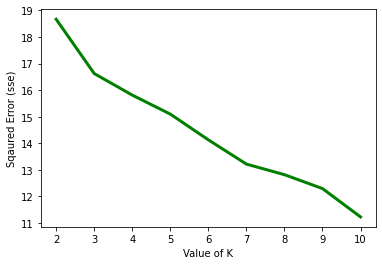

In [58]:
import matplotlib.pyplot as plt
sse =[]
Kmax= 10
Toronto_grouped_clustering = Toronto_grouped.drop('Neighborhood', 1)
for k in range(2, Kmax+1):
    KM = KMeans(n_clusters = k, max_iter = 500)
    KM.fit(Toronto_grouped_clustering)
      
    # calculates squared error
    sse.append(KM.inertia_)     
  
# plot the sse against K values
plt.plot(range(2, Kmax+1), sse, color ='g', linewidth ='3')
plt.xlabel("Value of K")
plt.ylabel("Sqaured Error (sse)")
plt.show() # clear the plot

### Getting the optimal value of K using silhouette_score

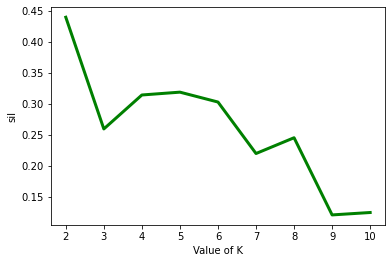

In [69]:
# getting the optimal value of K at highest silhouette_score
from sklearn.metrics import silhouette_score

sil = []
# dissimilarity would not be defined for a single cluster, thus, minimum number of clusters should be 2
for k in range(2, kmax+1):
    kmeans = KMeans(n_clusters = k, max_iter = 500).fit(Toronto_grouped_clustering)
    labels = kmeans.labels_
    sil.append(silhouette_score(Toronto_grouped_clustering, labels, metric = 'euclidean'))
    
# plot the sil against K values
plt.plot(range(2, Kmax+1), sil, color ='g', linewidth ='3')
plt.xlabel("Value of K")
plt.ylabel("sil")
plt.show()

### from the two methods it's clear thet the best value of K is 2, so let's run the model with this value

In [71]:
kclusters = 2
# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(Toronto_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int32)

###### creating a new dataframe that includes the cluster as well as the top 10 venues for each neighborhood.


In [72]:
# add clustering labels
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

Toronto_merged = Toronto_data

# merge Toronto_grouped with Toronto_data to add latitude/longitude for each neighborhood
Toronto_merged = Toronto_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')

Toronto_merged

,PostalCode,Borough,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.6555,-79.3626,1,Coffee Shop,Park,Breakfast Spot,Café,Bakery,Farmers Market,Spa,Mexican Restaurant,Distribution Center,French Restaurant
1,M5B,Downtown Toronto,"Garden District, Ryerson",43.6572,-79.3783,1,Café,Theater,Clothing Store,Sandwich Place,Music Venue,Tanning Salon,Burrito Place,Bakery,Electronics Store,Pizza Place
2,M5C,Downtown Toronto,St. James Town,43.6513,-79.3756,1,Café,Gastropub,Farmers Market,Coffee Shop,Japanese Restaurant,Middle Eastern Restaurant,Food Truck,Latin American Restaurant,Diner,New American Restaurant
3,M4E,East Toronto,The Beaches,43.6784,-79.2941,1,Pub,Health Food Store,Trail,Metro Station,Modern European Restaurant,Mobile Phone Shop,Miscellaneous Shop,Middle Eastern Restaurant,Mexican Restaurant,Yoga Studio
4,M5E,Downtown Toronto,Berczy Park,43.6456,-79.3754,1,Farmers Market,Beer Bar,Coffee Shop,Cocktail Bar,Seafood Restaurant,Breakfast Spot,Basketball Stadium,Liquor Store,Bistro,French Restaurant
5,M5G,Downtown Toronto,Central Bay Street,43.6564,-79.386,1,Coffee Shop,Café,Italian Restaurant,Yoga Studio,Sandwich Place,Sushi Restaurant,Bubble Tea Shop,Middle Eastern Restaurant,Modern European Restaurant,Ramen Restaurant
6,M6G,Downtown Toronto,Christie,43.6683,-79.4205,1,Grocery Store,Café,Park,Baby Store,Candy Store,Nightclub,Restaurant,Italian Restaurant,Coffee Shop,Organic Grocery
7,M5H,Downtown Toronto,"Richmond, Adelaide, King",43.6496,-79.3833,1,Coffee Shop,Café,Seafood Restaurant,Bakery,Sushi Restaurant,Steakhouse,Lounge,Fast Food Restaurant,Smoke Shop,Speakeasy
8,M6H,West Toronto,"Dufferin, Dovercourt Village",43.6655,-79.4378,1,Pharmacy,Bakery,Grocery Store,Music Venue,Brewery,Supermarket,Middle Eastern Restaurant,Bar,Bank,Café
9,M4J,East York/East Toronto,The Danforth East,43.6872,-79.3368,1,Convenience Store,Park,Intersection,Pizza Place,Massage Studio,Medical Center,Mediterranean Restaurant,Men's Store,Motel,Metro Station


#### Creating a map to visualize the Clusters

In [73]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(Toronto_merged['Latitude'], Toronto_merged['Longitude'], Toronto_merged['Neighborhood'], Toronto_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

### Examining each Cluster

### Cluster 1

In [74]:
Toronto_merged.loc[Toronto_merged['Cluster Labels'] == 0, Toronto_merged.columns[[1] + list(range(5, Toronto_merged.shape[1]))]]

,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue


### Cluster 2

In [75]:
Toronto_merged.loc[Toronto_merged['Cluster Labels'] == 1, Toronto_merged.columns[[1] + list(range(5, Toronto_merged.shape[1]))]]

,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Downtown Toronto,1,Coffee Shop,Park,Breakfast Spot,Café,Bakery,Farmers Market,Spa,Mexican Restaurant,Distribution Center,French Restaurant
1,Downtown Toronto,1,Café,Theater,Clothing Store,Sandwich Place,Music Venue,Tanning Salon,Burrito Place,Bakery,Electronics Store,Pizza Place
2,Downtown Toronto,1,Café,Gastropub,Farmers Market,Coffee Shop,Japanese Restaurant,Middle Eastern Restaurant,Food Truck,Latin American Restaurant,Diner,New American Restaurant
3,East Toronto,1,Pub,Health Food Store,Trail,Metro Station,Modern European Restaurant,Mobile Phone Shop,Miscellaneous Shop,Middle Eastern Restaurant,Mexican Restaurant,Yoga Studio
4,Downtown Toronto,1,Farmers Market,Beer Bar,Coffee Shop,Cocktail Bar,Seafood Restaurant,Breakfast Spot,Basketball Stadium,Liquor Store,Bistro,French Restaurant
5,Downtown Toronto,1,Coffee Shop,Café,Italian Restaurant,Yoga Studio,Sandwich Place,Sushi Restaurant,Bubble Tea Shop,Middle Eastern Restaurant,Modern European Restaurant,Ramen Restaurant
6,Downtown Toronto,1,Grocery Store,Café,Park,Baby Store,Candy Store,Nightclub,Restaurant,Italian Restaurant,Coffee Shop,Organic Grocery
7,Downtown Toronto,1,Coffee Shop,Café,Seafood Restaurant,Bakery,Sushi Restaurant,Steakhouse,Lounge,Fast Food Restaurant,Smoke Shop,Speakeasy
8,West Toronto,1,Pharmacy,Bakery,Grocery Store,Music Venue,Brewery,Supermarket,Middle Eastern Restaurant,Bar,Bank,Café
9,East York/East Toronto,1,Convenience Store,Park,Intersection,Pizza Place,Massage Studio,Medical Center,Mediterranean Restaurant,Men's Store,Motel,Metro Station
